## INT2 Project

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q /content/gdrive/MyDrive/kaggle/cifar10.zip -d /content/gdrive/MyDrive/

KeyboardInterrupt: ignored

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets

import time

In [5]:
!pip uninstall torchvision
!pip install torchvision

Found existing installation: torchvision 0.12.0+cu113
Uninstalling torchvision-0.12.0+cu113:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/torchvision-0.12.0+cu113.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libcudart.053364c0.so.11.0
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libnvjpeg.90286a3c.so.11
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libpng16.7f72a3c5.so.16
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libz.1328edc3.so.1
    /usr/local/lib/python3.7/dist-packages/torchvision/*
Proceed (y/n)? y
  Successfully uninstalled torchvision-0.12.0+cu113
     |████████████████████████████████| 21.0 MB 1.2 MB/s 


In [12]:
from torchvision.datasets.cifar import CIFAR10
TRAIN_DATA_PATH = "/content/gdrive/MyDrive/cifar10/train"
TEST_DATA_PATH = "/content/gdrive/MyDrive/cifar10/test"

transform = transforms.Compose(
    [transforms.AutoAugment(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


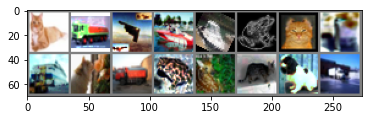

cat   truck plane ship  ship  frog  cat   bird  ship  cat   truck frog  deer  cat   dog   truck


In [6]:

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
#print(labels)

# show images
imgGrid = torchvision.utils.make_grid(images)
imshow(imgGrid)
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
writer = SummaryWriter("runs/small") #good one?
#tensorboard --logdir runs/testValidationError
writer.add_image("four images", imgGrid)
writer.flush()

In [31]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
            self.shortcut = nn.Sequential()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.drop1 = nn.Dropout(0.2)

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = nn.ReLU()(self.bn1(self.conv1(x)))
        x = nn.ReLU()(self.bn2(self.conv2(x)))
        x = self.drop1(x)
        x = x + shortcut
        return nn.ReLU()(x)

In [32]:
class Net(nn.Module):
    def __init__(self, resblock, in_channels=3, outputs=10):
        super().__init__()
        
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            resblock(32, 32, downsample=False),
            resblock(32, 32, downsample=False)
        )

        self.layer2 = nn.Sequential(
            resblock(32, 64, downsample=True),
            resblock(64, 64, downsample=False)
        )

        self.layer3 = nn.Sequential(
            resblock(64, 128, downsample=True),
            resblock(128, 128, downsample=False)
        )

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(128, 10)
        #self.fc1 = nn.Linear(32768, 10)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #x = self.layer4(x)
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

net = Net(ResBlock)

In [ ]:
#from torchsummary import summary

#net.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
#summary(resnet18, (3, 224, 224))

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

In [34]:
print(len(testloader))
print(len(trainloader))
start_time = time.time()
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print("labels", labels.shape, labels)
        #print("inputs", inputs.shape, inputs)
        #print("outputs", outputs.shape, outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f} time: {time.time() - start_time}')
            # Check against the validation set
            running_vloss = 0.0

            
            net.train(False) # Don't need to track gradents for validation
            for j, vdata in enumerate(testloader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True) # Turn gradients back on for training

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(testloader)

            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(trainloader) + i)
            running_loss = 0.0
    print(f'epoch time: {time.time() - start_time}')
print('Finished Training')

writer.flush()

625
3125
[1,  1000] loss: 1.760 time: 47.28837013244629
[1,  2000] loss: 1.486 time: 107.53793668746948
[1,  3000] loss: 1.376 time: 167.8464720249176
epoch time: 188.52641320228577
[2,  1000] loss: 1.268 time: 234.87116980552673
[2,  2000] loss: 1.205 time: 295.7461495399475
[2,  3000] loss: 1.149 time: 356.12247037887573
epoch time: 377.021169424057
[3,  1000] loss: 1.078 time: 423.6585285663605
[3,  2000] loss: 1.059 time: 482.6730167865753
[3,  3000] loss: 1.027 time: 541.4349992275238
epoch time: 561.9609823226929
[4,  1000] loss: 0.965 time: 607.3400406837463
[4,  2000] loss: 0.954 time: 666.5714385509491
[4,  3000] loss: 0.930 time: 725.9470899105072
epoch time: 746.0346968173981
[5,  1000] loss: 0.861 time: 789.4709293842316
[5,  2000] loss: 0.877 time: 847.5382528305054
[5,  3000] loss: 0.875 time: 906.4268414974213
epoch time: 926.6431205272675
[6,  1000] loss: 0.816 time: 971.053462266922
[6,  2000] loss: 0.817 time: 1029.454130411148
[6,  3000] loss: 0.816 time: 1087.297544

In [36]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 21 %
